In [97]:
def set_dates(TSRV, CSRV, ret):
    TSRV_mon = (TSRV.index+pd.tseries.offsets.BDay(1)).strftime('%Y-%m')
    start = TSRV_mon[0]

    CSRVtemp = TSRVtemp = ret[start:]* np.nan

    TSRVtemp = TSRV.reindex(TSRVtemp.index)
    TSRVtemp.iloc[0] = TSRV.iloc[0]
    TSRVtemp.ffill(inplace = True)

    CSRVtemp = CSRV.reindex(CSRVtemp.index)
    CSRVtemp.iloc[0] = CSRV.iloc[0]
    CSRVtemp.ffill(inplace = True)
    
    TSRV=TSRVtemp
    CSRV=CSRVtemp
    return TSRV, CSRV

def emvo_csrv_tsrv(Mag, Mag_short, RET, use_cols, CS =0.35, minobs1 = 12, nopos =0.4, WGT = [0.5, 0.5], WGT2 = [0.5, 0.5]):
    Mag = Mag.copy()[use_cols]
    Mag_short = Mag.copy()[use_cols]
    RET = RET.copy()[use_cols]
    
    Ret = RET.copy()
    
    RV = Mag
    RVrank = RV.iloc[minobs1-1:]* 0

    for i in range(minobs - minobs1):
        data=RV.iloc[:(minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]

    for i in range(minobs - minobs1+1, len(RV) - minobs1 + 1):
        data = RV.iloc[i -(minobs - minobs1): (minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]

    truecount = np.round((RVrank.shape[-1]-RVrank.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RVrank.columns)).reshape(RVrank.shape)

    tiebreaker = RVrank.rolling(5).mean().fillna(0)*0.0000001 #tie breaker what is this??

    tied_RVrank = RVrank + tiebreaker

    CSRV = tied_RVrank.rank(1, method = 'first')
    CSRV1 = tied_RVrank.rank(1, method = 'first', ascending = False)

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1


    Magrank=RVrank
    CSMagpos=CSRVpos


    RV = Mag_short

    RVrank = RV.iloc[minobs1-1:]* 0

    for i in range(minobs - minobs1):
        data=RV.iloc[:(minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]

    for i in range(minobs - minobs1+1, len(RV) - minobs1 + 1):
        data = RV.iloc[i -(minobs - minobs1): (minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]
    RV1 = RV.iloc[minobs1-1:]

    truecount = np.round((RVrank.shape[-1]-RVrank.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RVrank.columns)).reshape(RVrank.shape)

    tiebreaker = RVrank.rolling(5).mean().fillna(0)*0.0000001 #tie breaker what is this??

    tied_RVrank = RVrank + tiebreaker

    CSRV = tied_RVrank.rank(1, method = 'first')
    CSRV1 = tied_RVrank.rank(1, method = 'first', ascending = False)

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1


    Relrank=RVrank
    CSRelpos=CSRVpos

    CS_index = sorted(list(set(CSRelpos.index) & set(CSMagpos.index)))

    CSMagpos = CSMagpos.reindex(CS_index)
    CSRelpos = CSRelpos.reindex(CS_index)

    CSRV = CSRelpos * WGT2[0] + CSMagpos * WGT2[1]

    #translate to positions
    TS1 = Magrank *0

    TS1[Magrank > (nopos+(1-nopos)/2)] = 1
    TS1[Magrank < ((1-nopos)/2)] = -1

    TS2 = Relrank *0

    TS2[Relrank > (nopos+(1-nopos)/2)] = 1
    TS2[Relrank < ((1-nopos)/2)] = -1

    TS_index = sorted(list(set(TS1.index) & set(TS2.index)))

    TS1 = TS1.reindex(TS_index)
    TS2 = TS2.reindex(TS_index)

    TSRV=TS1*WGT[0]+TS2*WGT[1]



    TSRVstat1, CSRVstat1 = set_dates(TSRV, CSRV, RET)

    Ret=RET.copy()
    
    Retpos=Ret.copy()
    Retneg=Ret.copy()

    Retpos = Retpos[Retpos>=0]
    Retneg = Retneg[Retneg<=0]

    per=63

    STDpos = Retpos.rolling(per, min_periods = 1).std().iloc[per-1:]

    STDneg = Retneg.rolling(per, min_periods = 1).std().iloc[per-1:]

    RV= - STDpos+STDneg

    t = list(map(lambda x: True if x.weekday()+2 == RB1 else False, RV.index)) # weekday R에서 2를 더해야 같은 값

    RV = RV[t]

    RVrank = RV.iloc[minobs1-1:]* 0


    for i in range(len(RV) - minobs1 +1):
        data=RV.iloc[:(minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]

    truecount = np.round((RVrank.shape[-1]-RVrank.isna().sum(1)) * CS)

    truecount = np.repeat(truecount.values, len(RVrank.columns)).reshape(RVrank.shape)

    tiebreaker = RVrank.rolling(5).mean().fillna(0)*0.0000001 #tie breaker what is this??

    tied_RVrank = RVrank + tiebreaker

    CSRV = tied_RVrank.rank(1, method = 'first')
    CSRV1 = tied_RVrank.rank(1, method = 'first', ascending = False)

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1

    CSRV = CSRVpos
    CSRV.fillna(0, inplace = True)
    # TSRV
    TSRV = RVrank *0

    TSRV[RVrank > (nopos+(1-nopos)/2)] = 1
    TSRV[RVrank < ((1-nopos)/2)] = -1

    TSRVstat2, CSRVstat2 = set_dates(TSRV, CSRV, RET)

    new_index = sorted(list(set(TSRVstat1.index) & set(TSRVstat2.index)))

    TSRVstat1 = TSRVstat1.reindex(new_index)
    TSRVstat2 = TSRVstat2.reindex(new_index)
    CSRVstat1 = CSRVstat1.reindex(new_index)
    CSRVstat2 = CSRVstat2.reindex(new_index)


    TSRV=TSRVstat1*1+TSRVstat2
    CSRV=CSRVstat1*1+CSRVstat2
    
    return TSRV, CSRV



def emca_tsrv_csrv(carry, use_cols, CS = 0.35, minobs1= 12, nopos = 0.4):
    carry = carry.copy()[use_cols]
    #RV rank
    RV = carry.iloc[minobs1-1:]

    RVrank = RV.iloc[minobs1-1:]* 0

    for i in range(len(RV) - minobs1 +1):
        data=RV.iloc[:(minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]

    #CSRV
    RV1 = RV.iloc[minobs1-1:]
    truecount = np.round((RV1.shape[-1]-RV1.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RV1.columns)).reshape(RV1.shape)

    CSRV = RV1.rank(1, method = 'first')
    CSRV1 = RV1.rank(1, method = 'first', ascending = False)

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1

    CSRV = CSRVpos

    CSRV.fillna(0, inplace = True)

    # TSRV
    TSRV = RVrank *0

    TSRV[RVrank > (nopos+(1-nopos)/2)] = 1
    TSRV[RVrank < ((1-nopos)/2)] = -1
    return TSRV, CSRV

def emdy_csrv_tsrv(Rvalue, Rvalue2, use_cols, CS =0.35, minobs1 = 12, nopos =0.4):
    Rvalue = Rvalue.copy()[use_cols]
    Rvalue2 = Rvalue2.copy()[use_cols]
    RV = Rvalue

    RVrank = RV.iloc[minobs1-1:]* 0

    
    for i in range(minobs - minobs1):
        data=RV.iloc[:(minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]

    for i in range(minobs - minobs1+1, len(RV) - minobs1 + 1):
        data = RV.iloc[i -(minobs - minobs1): (minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]

    truecount = np.round((RVrank.shape[-1]-RVrank.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RVrank.columns)).reshape(RVrank.shape)

    tiebreaker = RVrank.rolling(5).mean().fillna(0)*0.0000001 #tie breaker what is this??

    tied_RVrank = RVrank + tiebreaker

    CSRV = tied_RVrank.rank(1, method = 'first')
    CSRV1 = tied_RVrank.rank(1, method = 'first', ascending = False)

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1

    RV = Rvalue2

    RVrank = RV.iloc[minobs1-1:]* 0

    for i in range(len(RV) - minobs1 +1):
        data=RV.iloc[:(minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]

    CSRV=CSRVpos.fillna(0)



    TSRV = RVrank *0

    TSRV[RVrank > (nopos+(1-nopos)/2)] = 1
    TSRV[RVrank < ((1-nopos)/2)] = -1
    TSRV.fillna(0, inplace = True)
    
    
    return CSRV, TSRV

def empe_csrv_tsrv(Rvalue, Rvalue2, use_cols, CS =0.35, minobs1 = 12, nopos =0.4):
    Rvalue = Rvalue.copy()[use_cols]
    Rvalue2 = Rvalue2.copy()[use_cols]
    RV = Rvalue

    RVrank = RV.iloc[minobs1-1:]* 0

    for i in range(len(RV) - minobs1 +1):
        data=RV.iloc[:(minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]

    truecount = np.round((RVrank.shape[-1]-RVrank.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RVrank.columns)).reshape(RVrank.shape)

    tiebreaker = RVrank.rolling(5).mean().fillna(0)*0.0000001 #tie breaker what is this??

    tied_RVrank = RVrank + tiebreaker

    CSRV = tied_RVrank.rank(1, method = 'first')
    CSRV1 = tied_RVrank.rank(1, method = 'first', ascending = False)

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1


    CSRV=CSRVpos.fillna(0)

    TSRV = RVrank *0

    TSRV[RVrank > (nopos+(1-nopos)/2)] = 1
    TSRV[RVrank < ((1-nopos)/2)] = -1
    TSRV.fillna(0, inplace = True)

    CSRV_price = CSRV
    TSRV_price = TSRV

    RV = Rvalue2

    RVrank = RV.iloc[minobs1-1:]* 0

    for i in range(len(RV) - minobs1 +1):
        data=RV.iloc[:(minobs1+i)].rank(pct = True)
        RVrank.iloc[i] = data.iloc[-1][(len(data) - data.isna().sum() )>= minobs1]

    truecount = np.round((RVrank.shape[-1]-RVrank.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RVrank.columns)).reshape(RVrank.shape)

    tiebreaker = RVrank.rolling(5).mean().fillna(0)*0.0000001 #tie breaker what is this??

    tied_RVrank = RVrank + tiebreaker

    CSRV = tied_RVrank.rank(1, method = 'first')
    CSRV1 = tied_RVrank.rank(1, method = 'first', ascending = False)

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1


    CSRV=CSRVpos.fillna(0)

    TSRV = RVrank *0

    TSRV[RVrank > (nopos+(1-nopos)/2)] = 1
    TSRV[RVrank < ((1-nopos)/2)] = -1
    TSRV.fillna(0, inplace = True)

    CSRV_ep = CSRV
    TSRV_ep = TSRV

    CSRV = CSRV_price * 0.8 + CSRV_ep
    TSRV = TSRV_ep
    return CSRV, TSRV
def empm_csrv_tsrv(Mag, Conroll, Mag_short, Conroll_short, strv, strv_short, use_cols, CS = 0.35, minobs1 = 52, nopos =0.4, WGT = [1/3, 1/3, 1/3], WGT2 = [1/3, 1/3, 0]):
    Mag = Mag.copy()[use_cols]
    Conroll = Conroll.copy()[use_cols]
    Mag_short = Mag_short.copy()[use_cols]
    Conroll_short = Conroll_short.copy()[use_cols]
    strv = strv.copy()[use_cols]
    strv_short = strv_short.copy()[use_cols]

    #long_momentum
    RV = Mag
    RVrank = RV.iloc[minobs-1:]* 0

    RV1 = RV.iloc[minobs1-1:]

    truecount = np.round((RV1.shape[-1]-RV1.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RV1.columns)).reshape(RV1.shape)

    CSRV = RV1.rank(1, method = 'first')
    CSRV1 = CSRV.shape[1] + 1 -CSRV

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1

    Relrank=RVrank
    CSRelpos=CSRVpos
    TSRel=RV.iloc[minobs1-1:]

    TS1= TSRel*0

    TS1[TSRel>0] = 1
    TS1[TSRel<0] = -1
    # long 
    RV = Conroll

    RVrank = RV.iloc[minobs-1:]* 0

    RV1 = RV.iloc[minobs1-1:]

    truecount = np.round((RV1.shape[-1]-RV1.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RV1.columns)).reshape(RV1.shape)

    CSRV = RV1.rank(1, method = 'first')
    CSRV1 = CSRV.shape[1] + 1 -CSRV

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1

    Relrank=RVrank
    CSConpos=CSRVpos
    TSRel=RV.iloc[minobs1-1:]

    TS2= TSRel*0

    TS2[TSRel>0.5] = 1
    TS2[TSRel<0.5] = -1

    TSRVL = TS1 * WGT[0] + TS2*WGT[2]

    CSRVL = CSRelpos*WGT[0]+CSConpos*WGT2[1]
    ## Short momentum
    RV = Mag_short

    RVrank = RV.iloc[minobs-1:]* 0

    RV1 = RV.iloc[minobs1-1:]

    truecount = np.round((RV1.shape[-1]-RV1.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RV1.columns)).reshape(RV1.shape)

    CSRV = RV1.rank(1, method = 'first')
    CSRV1 = CSRV.shape[1] + 1 -CSRV

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1

    Relrank=RVrank
    CSRelpos=CSRVpos
    TSRel=RV.iloc[minobs1-1:]

    TS1= TSRel*0

    TS1[TSRel>0] = 1
    TS1[TSRel<0] = -1
    # short
    RV = Conroll_short

    RVrank = RV.iloc[minobs-1:]* 0

    RV1 = RV.iloc[minobs1-1:]

    truecount = np.round((RV1.shape[-1]-RV1.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RV1.columns)).reshape(RV1.shape)

    CSRV = RV1.rank(1, method = 'first')
    CSRV1 = CSRV.shape[1] + 1 -CSRV

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1

    Relrank=RVrank
    CSConpos=CSRVpos
    TSRel=RV.iloc[minobs1-1:]

    TS2= TSRel*0

    TS2[TSRel>0.5] = 1
    TS2[TSRel<0.5] = -1
    # long momentum
    RV = strv.iloc[52-1:]

    RVrank = RV.iloc[minobs-1:]* 0

    RV1 = RV.iloc[minobs1-1:]

    truecount = np.round((RV1.shape[-1]-RV1.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RV1.columns)).reshape(RV1.shape)

    CSRV = RV1.rank(1, method = 'first')
    CSRV1 = RV1.rank(1, method = 'first', ascending = False)

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1

    Relrank=RVrank
    CSREVpos=CSRVpos
    # short momentum
    RV = strv_short.iloc[52-1:]

    RVrank = RV.iloc[minobs-1:]* 0

    RV1 = RV.iloc[minobs1-1:]

    truecount = np.round((RV1.shape[-1]-RV1.isna().sum(1)) * CS)
    truecount = np.repeat(truecount.values, len(RV1.columns)).reshape(RV1.shape)

    CSRV = RV1.rank(1, method = 'first')
    CSRV1 = RV1.rank(1, method = 'first', ascending = False)

    CSRVpos = CSRV* 0

    CSRVpos[CSRV<= truecount] = -1
    CSRVpos[CSRV1<= truecount] = 1

    Relrank=RVrank
    CSREV2pos=CSRVpos

    TSRVSh=TS1*WGT[0]+TS2*WGT[1]
    CSRVSh=CSREVpos*0.5+CSREV2pos.reindex(CSREVpos.index)

    TSRV = TSRVSh.reindex(TSRVL.index) * 0.5 + TSRVL

    CSRV=CSRVSh

    TSRV = TSRV.reindex(CSRVSh.index)
    return CSRV, TSRV



In [45]:
import pandas as pd
from utils import GRP_bt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from data_gen import em_data

name1 = 'tests'

EMRet, EMindex = em_data()

In [46]:
IRCSmod=0.8
IRTSmod=0.8
ComCSmod=0.8
ComTSmod=0.8
DMCSmod=1
EMCSmod=1
DMTSmod=1
EMTSmod=1
positions=1
updatepos=0
RBP=3
targetvol=0.0475
#targetvol=0.035
Volband=0.05
elimit=3.8

CSpos=0
CSpostest=0.35
CSNUM=0.35
CSNUM2=0.5
CSNUM3=0.5

TSWGT=1
CSWGT=1
RB1=3
RB2=3
RET = EMRet
index = EMindex
CSdesign = 'notional'
IDN = 'out'


# EMVO
- 다음과같이 국가를 나누어서 따로 적용
- 'CN', 'KR', 'TW', 'IN' : 
- 'MY', 'ID', 'BR', 'MX', 'RU', 'SA' :
- 환율의 price momentum(long and short)의 등수와
- 수익률의 표준편차(양수익률의 표준편차, 음수익률의 표준편차 더함)의 등수를
- 같은 비율로 섞어줌

In [47]:
#Magnitude
fx = pd.read_csv('./data/fx-em.csv',header=0, index_col=0, parse_dates=True)

# Ret=RET

minobs1=12
minobs=60
longlen=12
shortlen=0

nopos=0.4##middle section->neutral zone

CS=CSNUM # assets to long and short

group_1 = fx.columns[:4]
group_2 = fx.columns[4:]
WGT = np.array([0.5, 0.5])
if IDN == 'out':
    group_2= group_2.drop('ID')

# long term momentum
obs = len(fx) - longlen -1
Mag = fx.pct_change(longlen-shortlen).shift(shortlen).dropna().iloc[:obs+1]

#shor term momentum
longlen = 3
obs = len(fx) - longlen -1
#longlen- shortlen의 차이만큼 모멘텀, 
Mag_short = fx.pct_change(longlen-shortlen).shift(shortlen).dropna().iloc[:obs+1]


TSRV1, CSRV1 = emvo_csrv_tsrv(Mag, Mag_short, EMRet, use_cols = group_1, WGT = WGT, WGT2 = WGT)
TSRV2, CSRV2 = emvo_csrv_tsrv(Mag, Mag_short, EMRet, use_cols = group_2, WGT = WGT, WGT2 = WGT)

TSRV = pd.concat([TSRV1, TSRV2], 1).reindex(columns = fx.columns).fillna(0)
CSRV = pd.concat([CSRV1, CSRV2], 1).reindex(columns = fx.columns).fillna(0)

TSRV, CSRV = set_dates(TSRV, CSRV, EMRet.copy())

In [48]:

RB = 1
min_vol = .15
freq = 'month'


In [49]:
GRP_bt_test = GRP_bt('vol', EMRet, RB, min_vol, freq, factorsd = 12, assetsd =12, statsd = 12)


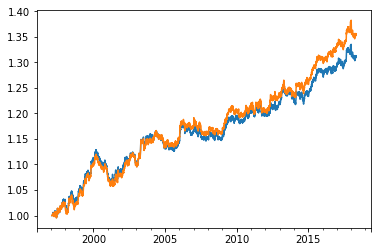

In [50]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()

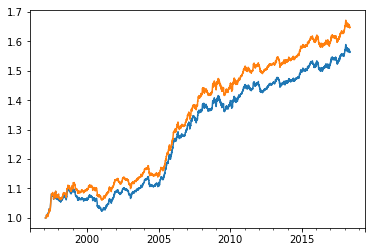

In [51]:

GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

# EMCA
- carry로 롱숏 구성
- 'MY', 'RU', 'BR' 빠짐 왜 빠지는지 모르겠음


In [52]:

name1 = 'EMCA'

In [53]:
carry = pd.read_csv('./data/carry-em.csv', index_col='Unnamed: 0', parse_dates= True)#, header = True)
use_col = carry.columns.drop(['MY', 'RU', 'BR', 'ID'])
minobs1=12
nopos=0.4##middle section->neutral zone

CSNUM3=0.5 
CS=CSNUM3 # assets to long and short

TSRV, CSRV = emca_tsrv_csrv(carry, use_col, CSNUM3, minobs1, nopos)

TSRV, CSRV = set_dates(TSRV, CSRV, EMRet.copy())

TSRV = TSRV.reindex(columns = EMRet.columns).fillna(0)
CSRV = CSRV.reindex(columns = EMRet.columns).fillna(0)

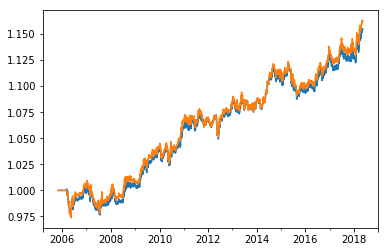

In [54]:
RB = 1
min_vol = .15
freq = 'month'

GRP_bt_test = GRP_bt('vol', EMRet, RB, min_vol, freq)
GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

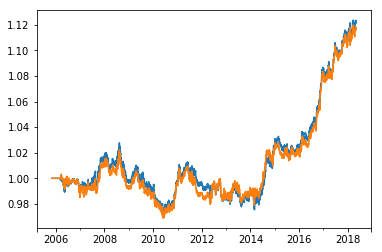

In [55]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()

# EMDY


In [56]:
price_index = pd.read_csv('./data/priceindex-mon-em.csv',header=0, index_col=0, parse_dates=True)
yield_ = pd.read_csv('./data/10Yield-em.csv',header=0, index_col=0, parse_dates=True)
DPS = pd.read_csv('./data/DPS-em.csv',header=0, index_col=0, parse_dates=True)
DPS1 = pd.read_csv('./data/DPS1-em.csv',header=0, index_col=0, parse_dates=True)

minobs1=12
minobs=60
nopos=0.4##middle section->neutral zone

CS=CSNUM # assets to long and short

group_1 = RET.columns[:4]
group_2 = RET.columns[4:]

if IDN == 'out':
    group_2= group_2.drop('ID')

DPS[DPS.isnull()] = DPS1[DPS.isnull()]

DYP = price_index.reindex(DPS.index)

DY=DPS/DYP

Rvalue=DY.reindex(yield_.index)

Rvalue = Rvalue.diff(3).dropna(how = 'all')

Rvalue2 = DY.reindex(yield_.index) -yield_/100

Rvalue2 = Rvalue2.iloc[3:]

CSRV1, TSRV1 = emdy_csrv_tsrv(Rvalue, Rvalue2, group_1,  CS)
CSRV2, TSRV2 = emdy_csrv_tsrv(Rvalue, Rvalue2, group_2,  CS)

TSRV = pd.concat([TSRV1, TSRV2], 1).reindex(columns = EMRet.columns).fillna(0)
CSRV = pd.concat([CSRV1, CSRV2], 1).reindex(columns = EMRet.columns).fillna(0)

TSRV, CSRV = set_dates(TSRV, CSRV, EMRet.copy())

TSRV = TSRV.reindex(columns = EMRet.columns)
CSRV = CSRV.reindex(columns = EMRet.columns)

In [58]:
RB = 1
min_vol = .15
freq = 'month'

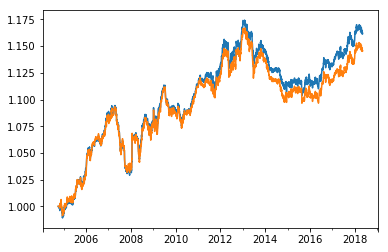

In [59]:
GRP_bt_test = GRP_bt('vol', EMRet, RB, min_vol, freq, factorsd = 12, assetsd =12, statsd = 12)


GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

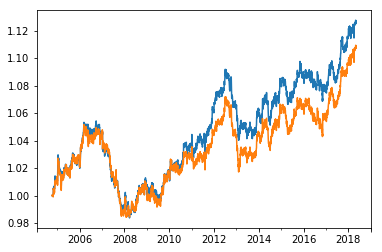

In [60]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()

# EMPE

In [61]:
price_index = pd.read_csv('./data/priceindex-mon-em.csv',header=0, index_col=0, parse_dates=True)
yield_ = pd.read_csv('./data/10Yield-em.csv',header=0, index_col=0, parse_dates=True)
EPS = pd.read_csv('./data/EPS-em.csv',header=0, index_col=0, parse_dates=True)
EPS1 = pd.read_csv('./data/EPS1-em.csv',header=0, index_col=0, parse_dates=True)

minobs1=12
minobs=60
nopos=0.4##middle section->neutral zone
CS = CSNUM

In [62]:
Rvalue = EPS/price_index.reindex(EPS.index)
Rvalue2 = EPS/EPS1

In [63]:
CSRV1, TSRV1 = empe_csrv_tsrv(Rvalue, Rvalue2, group_1, CS)
CSRV2, TSRV2 = empe_csrv_tsrv(Rvalue, Rvalue2, group_2, CS)

TSRV = pd.concat([TSRV1, TSRV2], 1).reindex(columns = EMRet.columns).fillna(0)
CSRV = pd.concat([CSRV1, CSRV2], 1).reindex(columns = EMRet.columns).fillna(0)

TSRV, CSRV = set_dates(TSRV, CSRV, EMRet.copy())

TSRV = TSRV.reindex(columns = EMRet.columns)
CSRV = CSRV.reindex(columns = EMRet.columns)

In [64]:
RB = 1
min_vol = .15
freq = 'month'

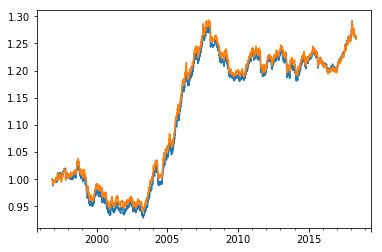

In [65]:
GRP_bt_test = GRP_bt('vol', EMRet, RB, min_vol, freq, factorsd = 12, assetsd =12, statsd = 12)


GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

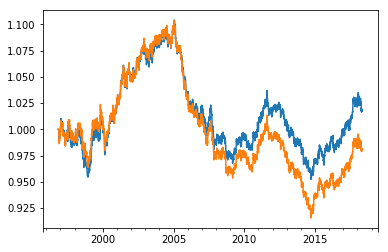

In [66]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()

# EMPM

In [67]:
RB1=3

targetvol=0.0475
minobs1=52
minobs=260
longlen=52
shortlen=2
nopos=0.4##middle section->neutral zone
SDEV=12

WGT=np.array([1/3,1/3,1/3])
WGT2=np.array([1,1,0])/3

CS=CSNUM

In [69]:
t = list(map(lambda x: True if x.weekday()+2 == RB1 else False, EMindex.index)) # weekday R에서 2를 더해야 같은 값

In [70]:
index = EMindex[t]

In [71]:
ret = index.pct_change().dropna()

up = ret * 0 
up[ret>=0] = 1

In [115]:
longlen = 52
obs = len(index) - longlen -1
Mag = index.pct_change(longlen-shortlen).shift(shortlen).dropna().iloc[:obs+1]
Conroll = (up.rolling(longlen-shortlen).sum()/(longlen-shortlen)).shift(shortlen).dropna()

longlen = 13
obs = len(index) - longlen -1
Mag_short = index.pct_change(longlen-shortlen).shift(shortlen).dropna().iloc[:obs+1]
Conroll_short = (up.rolling(longlen-shortlen).sum()/(longlen-shortlen)).shift(shortlen).dropna()

strv = -index.pct_change(4).dropna()
strv_short = -ret.copy()
# std로도 RV값을 더해주었는데 주석처리 되어있음? -> 왜?
# stdev = (ret.rolling(longlen).std() * np.sqrt(52)).dropna()
# common = sorted(list(set(stdev.index) & set(Mag.index)))
# stdev = stdev.reindex(common)

In [145]:
CSRV1, TSRV1 = empm_csrv_tsrv(Mag,
                              Conroll, 
                              Mag_short,
                              Conroll_short, 
                              strv, 
                              strv_short, group_1)
CSRV2, TSRV2 = empm_csrv_tsrv(Mag,
                              Conroll, 
                              Mag_short,
                              Conroll_short, 
                              strv, 
                              strv_short, group_2, CS, minobs1, nopos, WGT = WGT, WGT2 = WGT2)

TSRV = pd.concat([TSRV1, TSRV2], 1).reindex(columns = EMRet.columns).fillna(0)
CSRV = pd.concat([CSRV1, CSRV2], 1).reindex(columns = EMRet.columns).fillna(0)



In [146]:
TSRV, CSRV = set_dates(TSRV, CSRV, EMRet.copy())

In [152]:
RB = 1
min_vol = .15
freq = 'month'

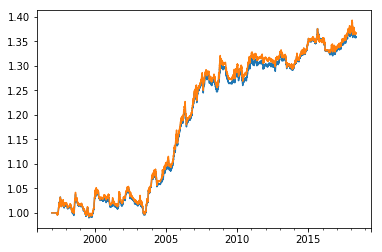

In [153]:
GRP_bt_test = GRP_bt('vol', EMRet, RB, min_vol, freq)


GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

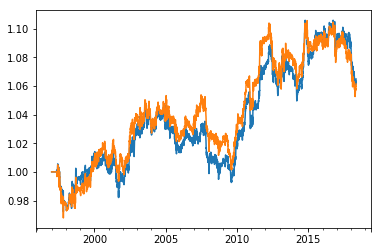

In [154]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()